# main code

/usr/lib64/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


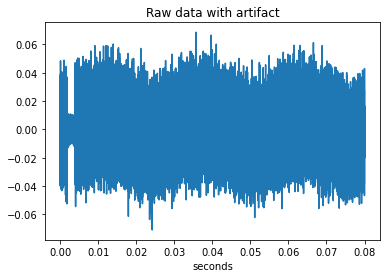

Base offset is 0.0524288 seconds


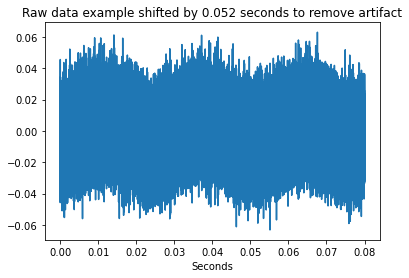

ant1 datatime: 0.08, ant2 datatime: 0.04


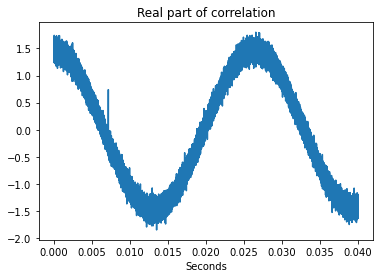

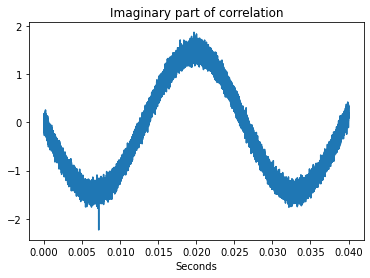

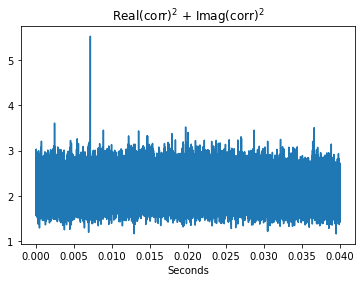

Delay found (after base delay): 17922 samples or 0.0071688 seconds
FFT window: 1024 samples or 0.0004096 seconds
measure samples:  74999808 total of  29.9999232 seconds


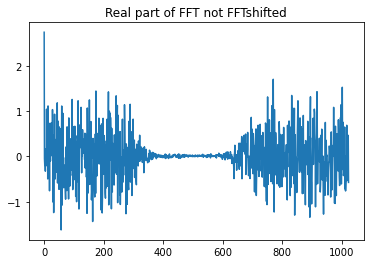

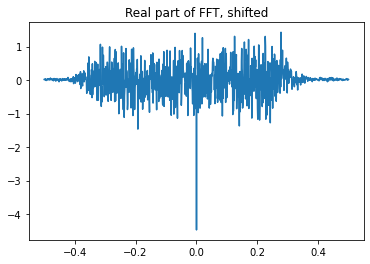

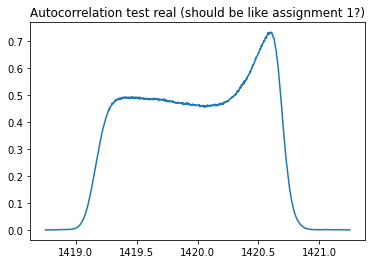

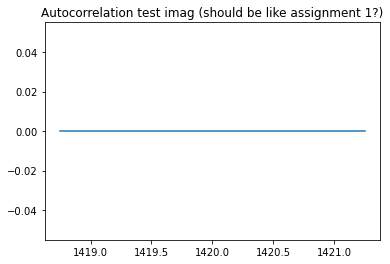

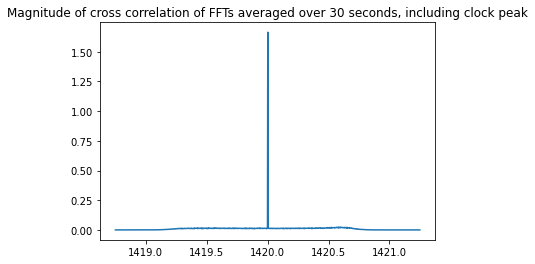

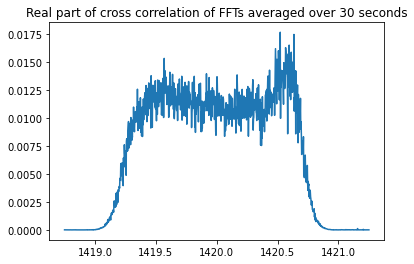

line at:  -0.5849683622408636


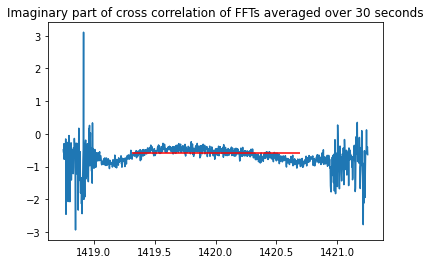

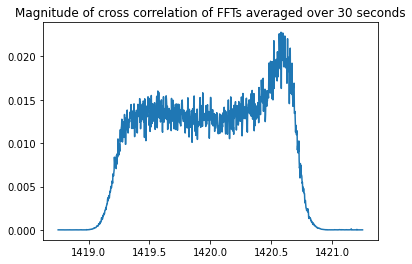

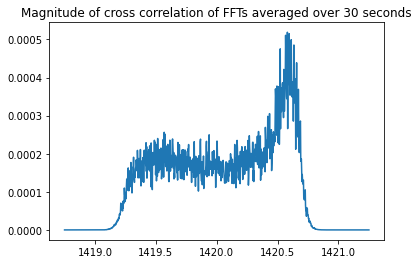

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal


filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"

# filename2 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.10.06.grc"
# filename1 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.10.06.grc"
# filename1 = filename8
# filename2 = filename7


wrongdata = np.fromfile(filename1, dtype=np.complex64, count=200000, offset=0)
plt.plot(np.arange(len(wrongdata)) / (2.5*1e6), wrongdata)
plt.title("Raw data with artifact")
plt.xlabel("seconds")
plt.savefig("reportplots/rawdata", dpi=300)
plt.show()

#base offset is needed to filter out weird effect at the start of each signal
base_offset = 2**17 #in nr samples
print(f"Base offset is {base_offset / (2.5*1e6)} seconds")

#Take some part of antenna 1 and a small part of antenna 2 and correlate antenna 2 across antenna 1
rawdata1 = np.fromfile(filename1, dtype=np.complex64, count=200000, offset=base_offset*8)
rawdata2 = np.fromfile(filename2, dtype=np.complex64, count=100000, offset=base_offset*8)

plt.plot(np.arange(len(rawdata1)) / (2.5*1e6), rawdata1)
plt.title(f"Raw data example shifted by {base_offset / (2.5*1e6):.3f} seconds to remove artifact")
plt.xlabel("Seconds")
plt.savefig("reportplots/rawdatashifted", dpi=300)
plt.show()



print(f"ant1 datatime: {200000/(2.5*1e6)}, ant2 datatime: {100000/(2.5*1e6)}")

corr = signal.correlate(rawdata1, rawdata2, mode="valid") #mode valid means no zero padding at the beginning and end
# corr = rawdata1 * np.conj(rawdata2)

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.real(corr))
plt.title("Real part of correlation")
plt.xlabel("Seconds")
plt.savefig("reportplots/realcorr", dpi=300)
plt.show()

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.imag(corr))
plt.title("Imaginary part of correlation")
plt.xlabel("Seconds")
plt.savefig("reportplots/imagcorr", dpi=300)
plt.show()

plt.plot(signal.correlation_lags(len(rawdata1), len(rawdata2), mode="valid") / (2.5*1e6), np.real(corr)**2 + np.imag(corr)**2)
plt.title(f"Real(corr)$^2$ + Imag(corr)$^2$")
plt.xlabel("Seconds")
plt.savefig("reportplots/magcorr", dpi=300)
plt.show()



delay_samples = np.argmax(np.real(corr)**2 + np.imag(corr)**2)
print(f"Delay found (after base delay): {delay_samples} samples or {delay_samples /  (2.5*1e6)} seconds")


nrchan = 2**10#int(2**16)
t_in_chan = nrchan / (2.5*1e6)
print(f"FFT window: {nrchan} samples or {t_in_chan} seconds")

#make the total number of samples a multiple of the size of the FFT window
measure_time = 30 #seconds
nr_samples = int(measure_time*(2.5*1e6) - measure_time*(2.5*1e6)%nrchan)
print("measure samples: ", nr_samples, "total of ", nr_samples/(2.5*1e6), "seconds")
# print(2**22)

data1_5sec = np.fromfile(filename1, dtype=np.complex64, count=nr_samples, offset=base_offset*8 + delay_samples*8)
data2_5sec = np.fromfile(filename2, dtype=np.complex64, count=nr_samples, offset=base_offset*8)

data1_5sec = data1_5sec.reshape(int(nr_samples/nrchan), nrchan)
data2_5sec = data2_5sec.reshape(int(nr_samples/nrchan), nrchan)

FFT1 = np.fft.fft(data1_5sec, axis=1)
FFT2 = np.fft.fft(data2_5sec, axis=1)

plt.plot(range(len(FFT1[0])), np.real(FFT1[0]))
plt.title("Real part of FFT not FFTshifted")
plt.savefig("reportplots/realFFTnonshifted", dpi=300)
plt.show()

# test = np.mean(FFT1 * np.conj(FFT2), axis=0)

# plt.plot(np.arange(len(test)), test)
# plt.plot(np.arange(len(test)), test)
# plt.show()
FFT1 = np.fft.fftshift(FFT1)
FFT2 = np.fft.fftshift(FFT2)



freqs = np.fft.fftshift(np.fft.fftfreq(len(FFT1[0])))


plt.plot(freqs, np.real(FFT1[0]))
plt.title("Real part of FFT, shifted")
plt.savefig("reportplots/realFFT", dpi=300)
plt.show()


autocorrelation = np.mean(FFT1 * np.conj(FFT1), axis=0)
iprange = 3
left_index = np.argmax(autocorrelation)-iprange
right_index = np.argmax(autocorrelation)+iprange
autocorrelation[left_index:right_index] = np.linspace(autocorrelation[left_index], autocorrelation[right_index], 2*iprange)
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.real(autocorrelation))
plt.title("Autocorrelation test real (should be like assignment 1?)")
plt.savefig("reportplots/realAutocorr", dpi=300)
plt.show()
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.angle(autocorrelation))
plt.title("Autocorrelation test imag (should be like assignment 1?)")
plt.savefig("reportplots/imagAutocorr", dpi=300)
plt.show()

# autocorrelation = np.mean(FFT2 * np.conj(FFT2), axis=0)
# iprange = 20
# left_index = np.argmax(autocorrelation)-iprange
# right_index = np.argmax(autocorrelation)+iprange
# autocorrelation[left_index:right_index] = np.linspace(autocorrelation[left_index], autocorrelation[right_index], 2*iprange)
# plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.real(autocorrelation))
# plt.title("Autocorrelation test real (should be like assignment 1?)")
# plt.show()
# plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.imag(autocorrelation))
# plt.title("Autocorrelation test imag (should be like assignment 1?)")
# plt.show()

crosscorr = np.mean(FFT1 * np.conj(FFT2), axis=0)
plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(crosscorr)), np.abs(crosscorr))
plt.title(f"Magnitude of cross correlation of FFTs averaged over {measure_time} seconds, including clock peak")
plt.savefig("reportplots/magcrosscorrwithpeak", dpi=300)
plt.show()

iprange = 1
left_index = np.argmax(np.abs(crosscorr))-iprange
right_index = np.argmax(np.abs(crosscorr))+iprange
crosscorr[left_index:right_index] = np.linspace(crosscorr[left_index], crosscorr[right_index], 2*iprange)

freqs = np.linspace(1420 - 1.25, 1420 + 1.25, len(crosscorr))
plt.plot(freqs, np.abs(np.real(crosscorr)))
plt.title(f"Real part of cross correlation of FFTs averaged over {measure_time} seconds")
plt.savefig("reportplots/realcrosscorr", dpi=300)
plt.show()
plt.plot(freqs, np.angle(crosscorr))
plt.title(f"Imaginary part of cross correlation of FFTs averaged over {measure_time} seconds")
plt.savefig("reportplots/imagcrosscorr", dpi=300)
avg_angle = np.average(np.angle(crosscorr)[230:-230])
plt.hlines(avg_angle, freqs[230], freqs[-230], colors="red")
print("line at: ", avg_angle)
plt.show()
plt.plot(freqs, np.abs(crosscorr))
plt.title(f"Magnitude of cross correlation of FFTs averaged over {measure_time} seconds")
plt.savefig("reportplots/magcrosscorr", dpi=300)
plt.show()

plt.plot(freqs, np.real(crosscorr)**2 + np.imag(crosscorr)**2)
plt.title(f"Magnitude of cross correlation of FFTs averaged over {measure_time} seconds")
plt.show()

# easier main code test

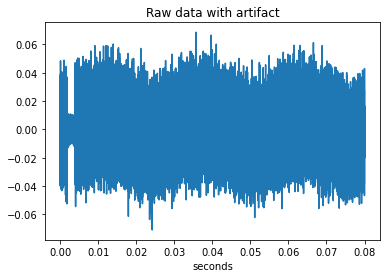

Base offset is 0.016 seconds


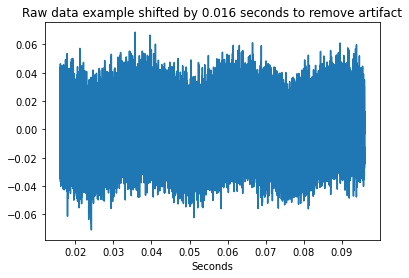

Find delay using 0.08 of antenna 1 and 0.04 of antenna 2


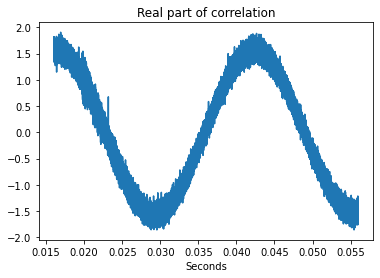

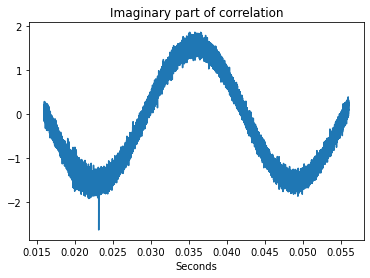

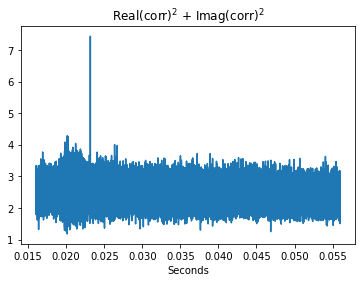

Delay found (after base delay): 17922 samples or 0.0071688 seconds


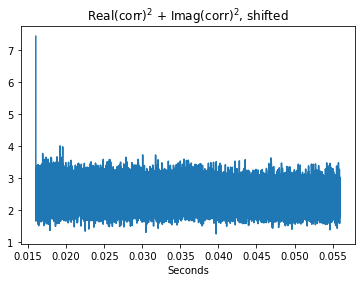

FFT window: 1024 samples or 0.0004096 seconds
measure samples:  12499968 total of  4.9999872 seconds


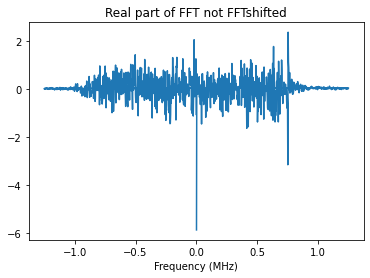

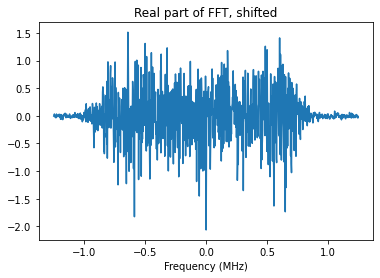

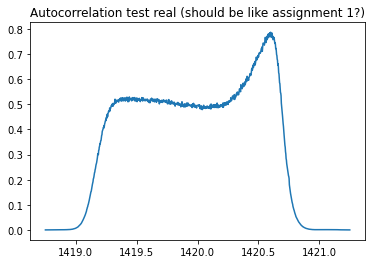

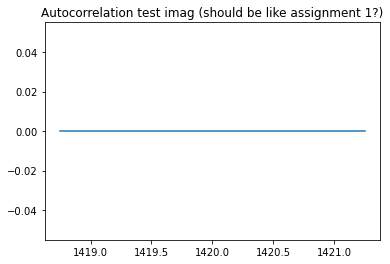

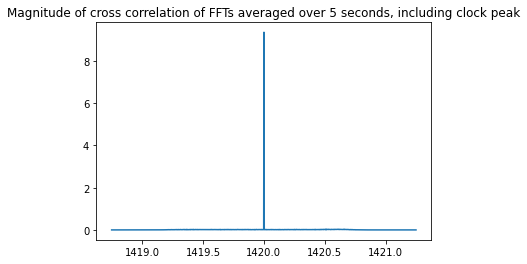

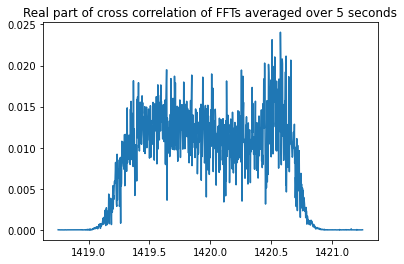

line at:  -0.6930158162313872


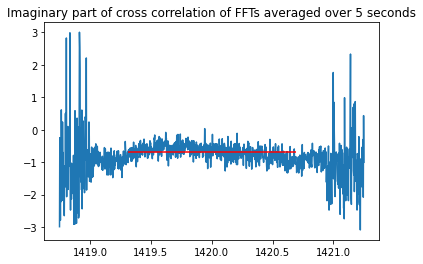

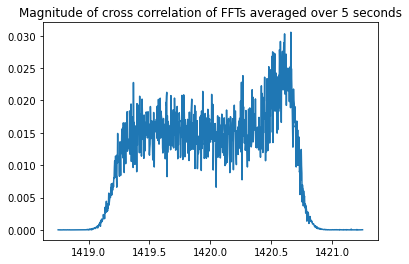

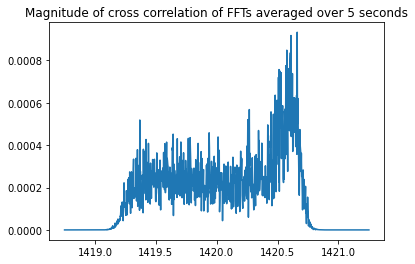

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal

save_files = False
nrchan = 1024
measure_time = 5

sample_freq = 2.5*1e6

filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"

nr_samples = int(measure_time*sample_freq - measure_time*sample_freq%nrchan)
x = np.arange(nr_samples)/sample_freq

data1 = np.fromfile(filename1, dtype=np.complex64, count=nr_samples)
data2 = np.fromfile(filename2, dtype=np.complex64, count=nr_samples)


startdata = data1[:200000]
startx = x[:200000]
plt.plot(startx, startdata)
plt.title("Raw data with artifact")
plt.xlabel("seconds")
plt.savefig("reportplots/rawdata", dpi=300)
plt.show()

#base offset is needed to filter out weird effect at the start of each signal
base_offset = 40000 #in nr samples
print(f"Base offset is {base_offset/sample_freq} seconds")


#Take some part of antenna 1 and a small part of antenna 2 and correlate antenna 2 across antenna 1
delaysize1 = 200000
delaysize2 = 100000
delaydata1 = data1[base_offset:base_offset + delaysize1]
delaydata2 = data2[base_offset:base_offset + delaysize2]
delayx1 = x[base_offset:base_offset + delaysize1]
# delayx2 = x[base_offset:base_offset + delaysize2]

plt.plot(delayx1, delaydata1)
plt.title(f"Raw data example shifted by {base_offset / sample_freq:.3f} seconds to remove artifact")
plt.xlabel("Seconds")
plt.savefig("reportplots/rawdatashifted", dpi=300)
plt.show()


print(f"Find delay using {delaysize1/sample_freq} of antenna 1 and {delaysize2/sample_freq} of antenna 2")

corr = signal.correlate(delaydata1, delaydata2, mode="valid") #mode valid means no zero padding at the beginning and end
corrx = x[base_offset:base_offset + delaysize1 - delaysize2 + 1]

plt.plot(corrx, np.real(corr))
plt.title("Real part of correlation")
plt.xlabel("Seconds")
plt.savefig("reportplots/realcorr", dpi=300)
plt.show()

plt.plot(corrx, np.imag(corr))
plt.title("Imaginary part of correlation")
plt.xlabel("Seconds")
plt.savefig("reportplots/imagcorr", dpi=300)
plt.show()

plt.plot(corrx, np.real(corr)**2 + np.imag(corr)**2)
plt.title(f"Real(corr)$^2$ + Imag(corr)$^2$")
plt.xlabel("Seconds")
plt.savefig("reportplots/magcorr", dpi=300)
plt.show()

delay_samples = np.argmax(np.real(corr)**2 + np.imag(corr)**2)
print(f"Delay found (after base delay): {delay_samples} samples or {delay_samples/sample_freq} seconds")

delaydata1 = data1[base_offset + delay_samples:base_offset + delaysize1 + delay_samples]
delaydata2 = data2[base_offset:base_offset + delaysize2]
corr = signal.correlate(delaydata1, delaydata2, mode="valid")
plt.plot(corrx, np.real(corr)**2 + np.imag(corr)**2)
plt.title(f"Real(corr)$^2$ + Imag(corr)$^2$, shifted")
plt.xlabel("Seconds")
plt.savefig("reportplots/magcorrshifted", dpi=300)
plt.show()


print(f"FFT window: {nrchan} samples or {nrchan/sample_freq} seconds")
print("measure samples: ", nr_samples, "total of ", nr_samples/(2.5*1e6), "seconds")

nrwindows = int((nr_samples-base_offset-delay_samples) / nrchan)

data1 = data1[base_offset+delay_samples:base_offset+delay_samples+nrwindows*nrchan].reshape(nrwindows, nrchan)
data2 = data2[base_offset:base_offset+nrwindows*nrchan].reshape(nrwindows, nrchan)
x = x[base_offset:base_offset+nrchan]

FFT1 = np.fft.fft(data1, axis=1)
FFT2 = np.fft.fft(data2, axis=1)

freqs = np.fft.fftfreq(len(x), d=1e6/sample_freq)

plt.plot(freqs, np.real(FFT1[0]))
plt.title("Real part of FFT not FFTshifted")
plt.xlabel("Frequency (MHz)")
plt.savefig("reportplots/realFFTnonshifted", dpi=300)
plt.show()


FFT1 = np.fft.fftshift(FFT1)
FFT2 = np.fft.fftshift(FFT2)
freqs = np.fft.fftshift(freqs)


plt.plot(freqs, np.real(FFT1[0]))
plt.title("Real part of FFT, shifted")
plt.xlabel("Frequency (MHz)")
plt.savefig("reportplots/realFFT", dpi=300)
plt.show()

crosscorr = np.mean(FFT1 * np.conj(FFT2), axis=0)

plt.plot(freqs, np.absolute(crosscorr))
plt.title(f"Magnitude of cross correlation of FFTs averaged over {measure_time} seconds, including clock peak")
plt.savefig("reportplots/magcrosscorrwithpeak", dpi=300)
plt.show()

interpolationrange = 1
left_index = np.argmax(np.abs(crosscorr))-interpolationrange
right_index = np.argmax(np.abs(crosscorr))+interpolationrange
crosscorr[left_index:right_index] = np.linspace(crosscorr[left_index], crosscorr[right_index], 2*interpolationrange)

plt.plot(freqs, np.absolute(np.real(crosscorr)))
plt.title(f"Real part of cross correlation of FFTs averaged over {measure_time} seconds")
plt.savefig("reportplots/realcrosscorr", dpi=300)
plt.show()

plt.plot(freqs, np.angle(crosscorr))
plt.title(f"Imaginary part of cross correlation of FFTs averaged over {measure_time} seconds")
plt.savefig("reportplots/imagcrosscorr", dpi=300)
avg_range = int(nrchan/4)
avg_angle = np.average(np.angle(crosscorr)[avg_range:-avg_range])
plt.hlines(avg_angle, freqs[avg_range], freqs[-avg_range], colors="red")
plt.show()

print("line at: ", avg_angle)


# autocorrelations

Base offset is 0.0524288 seconds
/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc
FFT window: 1024 samples or 0.0004096 seconds


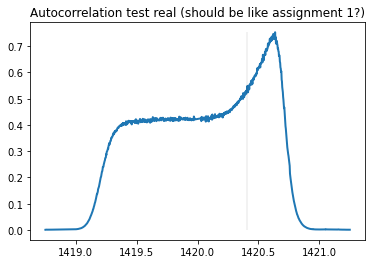

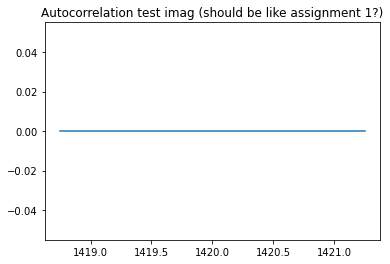

/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc
FFT window: 1024 samples or 0.0004096 seconds


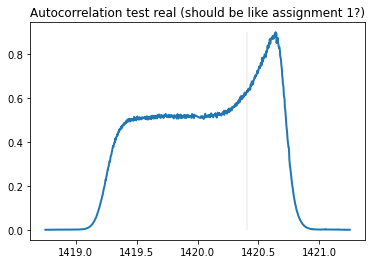

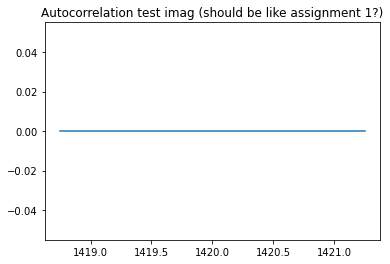

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal

filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"

names = [filename1, filename2, filename3, filename4, filename5, filename6, filename7, filename8]

#base offset is needed to filter out weird effect at the start of each signal
base_offset = 2**17 #in nr samples
print(f"Base offset is {base_offset / (2.5*1e6)} seconds")


for i in names[6:]:
    print(i)
    nrchan = 2**10#int(2**16)
    t_in_chan = nrchan / (2.5*1e6)
    print(f"FFT window: {nrchan} samples or {t_in_chan} seconds")

    #make the total number of samples a multiple of the size of the FFT window
    measure_time = 5 #seconds
    nr_samples = int(measure_time*(2.5*1e6) - measure_time*(2.5*1e6)%nrchan)


    data = np.fromfile(i, dtype=np.complex64, count=nr_samples, offset=base_offset*8).reshape(int(nr_samples/nrchan), nrchan)

    FFT = np.fft.fft(data, axis=1)
    FFT = np.fft.fftshift(FFT)

    autocorrelation = np.mean(FFT * np.conj(FFT), axis=0)
    iprange = 10
    left_index = np.argmax(autocorrelation)-iprange
    right_index = np.argmax(autocorrelation)+iprange
    autocorrelation[left_index:right_index] = np.linspace(autocorrelation[left_index], autocorrelation[right_index], 2*iprange)
    plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.real(autocorrelation), linewidth=2)
    plt.title("Autocorrelation test real (should be like assignment 1?)")
    plt.vlines([1420.40575], 0, np.max(autocorrelation), linewidth=0.1, colors="black")
    plt.savefig("autocorr_test", dpi=500)
    plt.show()
    plt.plot(np.linspace(1420 - 1.25, 1420 + 1.25, len(autocorrelation)), np.imag(autocorrelation))
    plt.title("Autocorrelation test imag (should be like assignment 1?)")
    plt.show()


# Finding delays

In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal

In [10]:
delta_freq = 2.5 * u.MHz
sample_interval = (1 / (2 * delta_freq)).to(u.s)


# nrchan = 32768*8*8*2*8 #0.0131 seconds
nrchan = int(2**22/8)
t = nrchan / (2.5*1e6)
print(t, "seconds")

# filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202314.37.31.grc"
# filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202314.37.31.grc"
# filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202314.37.28.grc"
# filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202314.37.28.grc"
# filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202314.37.26.grc"
# filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202314.37.26.grc"
# filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202314.37.29.grc"
# filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202314.37.29.grc"


filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"

start_offsets = [3, 3, 0, 0, 1, 1, 2, 2]
start_offsets = [0, 0, 3, 3, 2, 2, 1, 1]
names = [filename1, filename2, filename3, filename4, filename5, filename6, filename7, filename8]

base_offset = 2**15 #in nr samples

0.2097152 seconds


check 0.08 seconds


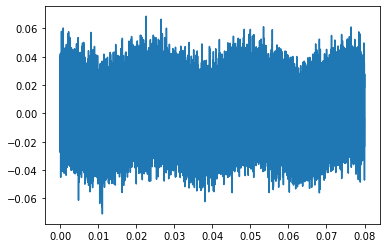

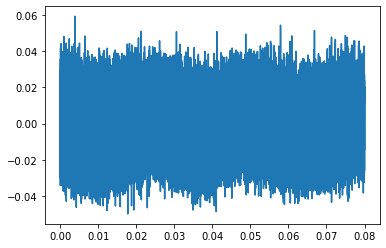

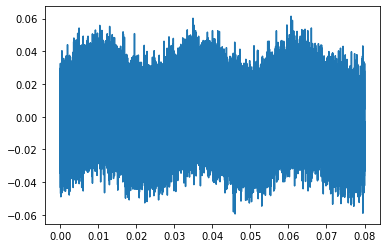

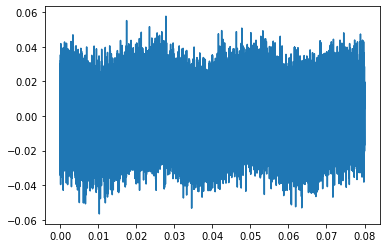

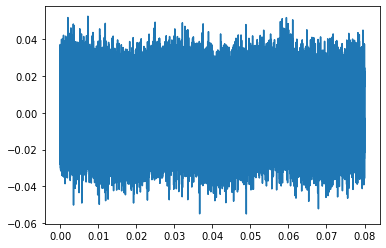

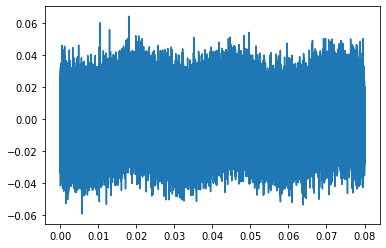

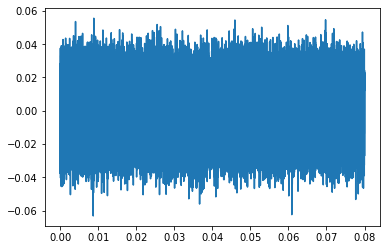

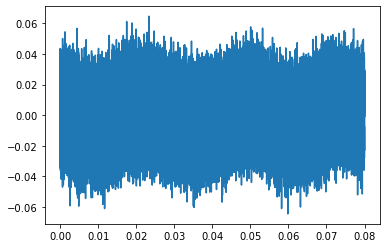

In [3]:
#find starting artifacts
count = 200000
print(f"check {count / (2.5*1e6)} seconds")
for name in names:
    data = np.fromfile(name, dtype=np.complex64, count=200000, offset=base_offset*8)
    plt.plot(np.arange(len(data)) / (2.5*1e6), np.real(data))
    plt.show()
    # data = np.fromfile(name, dtype=np.complex64, count=200000, offset=base_offset*8)
    # plt.plot(np.arange(len(data)) / (2.5*1e6), np.real(data))
    # plt.show()

(0, 1) 0 0
(0, 2) 0 60000000
(0, 3) 0 60000000
(0, 4) 0 40000000
(0, 5) 0 40000000
(0, 6) 0 20000000
(0, 7) 0 20000000
(1, 0) 0 0
(1, 2) 0 60000000
(1, 3) 0 60000000
(1, 4) 0 40000000
(1, 5) 0 40000000
(1, 6) 0 20000000
(1, 7) 0 20000000
(2, 0) 60000000 0
(2, 1) 60000000 0
(2, 3) 60000000 60000000
(2, 4) 60000000 40000000
(2, 5) 60000000 40000000
(2, 6) 60000000 20000000
(2, 7) 60000000 20000000
(3, 0) 60000000 0
(3, 1) 60000000 0
(3, 2) 60000000 60000000
(3, 4) 60000000 40000000
(3, 5) 60000000 40000000
(3, 6) 60000000 20000000
(3, 7) 60000000 20000000
(4, 0) 40000000 0
(4, 1) 40000000 0
(4, 2) 40000000 60000000
(4, 3) 40000000 60000000
(4, 5) 40000000 40000000
(4, 6) 40000000 20000000
(4, 7) 40000000 20000000
(5, 0) 40000000 0
(5, 1) 40000000 0
(5, 2) 40000000 60000000
(5, 3) 40000000 60000000
(5, 4) 40000000 40000000
(5, 6) 40000000 20000000
(5, 7) 40000000 20000000
(6, 0) 20000000 0
(6, 1) 20000000 0
(6, 2) 20000000 60000000
(6, 3) 20000000 60000000
(6, 4) 20000000 40000000
(6, 5) 

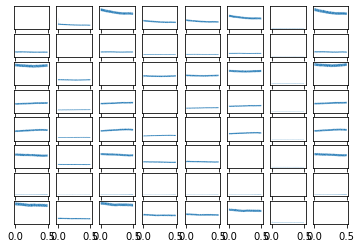

In [18]:
import itertools

indices = itertools.permutations(np.arange(8), 2)

corr_time = 1 #seconds
corr_samples = corr_time * 2.5*1e6

fig, axs = plt.subplots(8, 8, sharex=True, sharey=True)
for pair in indices:
    data1 = np.fromfile(names[pair[0]], dtype=np.complex64, count=int(corr_samples), offset=base_offset*8 + int(start_offsets[pair[0]]*(2.5*1e6)*8))
    data2 = np.fromfile(names[pair[1]], dtype=np.complex64, count=int(corr_samples/2), offset=base_offset*8 + int(start_offsets[pair[1]]*(2.5*1e6)*8))
    corr = signal.correlate(data1, data2, mode="valid")
    x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
    axs[pair[0], pair[1]].plot(x, np.real(corr)**2 + np.imag(corr)**2, linewidth=0.05)
    
    print(pair, int(start_offsets[pair[0]]*(2.5*1e6)*8), int(start_offsets[pair[1]]*(2.5*1e6)*8))

for ax_r in axs:
    for ax in ax_r:
        ax.get_yaxis().set_visible(False)


plt.savefig("find_delays", dpi=1000)
plt.show()


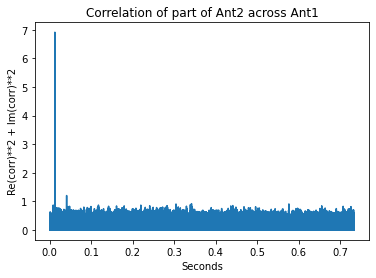

In [30]:
data1 = np.fromfile(names[7], dtype=np.complex64, count=int(2**18)*8, offset=base_offset*8)
data2 = np.fromfile(names[6], dtype=np.complex64, count=int(2**18), offset=base_offset*8)
corr = signal.correlate(data1, data2, mode="valid")
x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
plt.xlabel("Seconds")
plt.ylabel("Re(corr)**2 + Im(corr)**2")
plt.title("Correlation of part of Ant2 across Ant1")
# plt.savefig("delay_correlation", dpi=500)
plt.show()

delay_sample = np.argmax(np.real(corr)**2 + np.imag(corr)**2)

1.6777216 seconds correlated


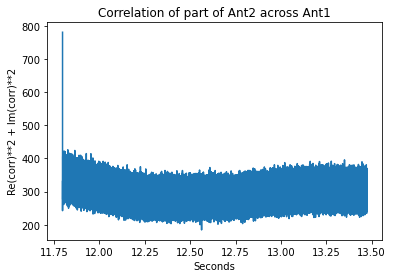

correlation at sample: 0
1.6777216 seconds correlated


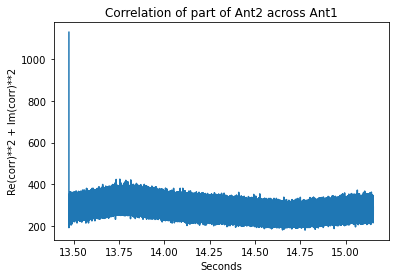

correlation at sample: 0
1.6777216 seconds correlated


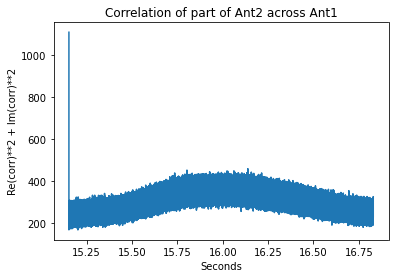

correlation at sample: 0
1.6777216 seconds correlated


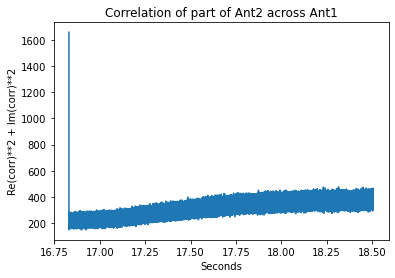

correlation at sample: 0
1.6777216 seconds correlated


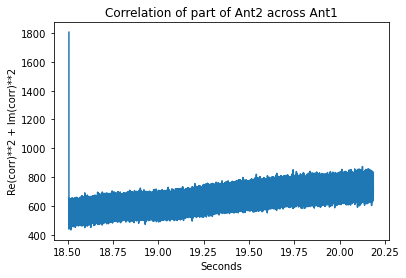

correlation at sample: 0
1.6777216 seconds correlated


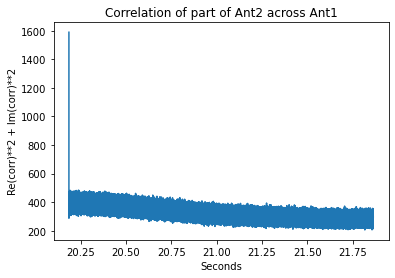

correlation at sample: 0
1.6777216 seconds correlated


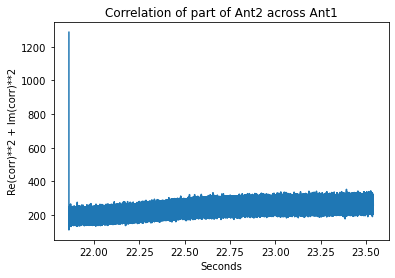

correlation at sample: 0
1.6777216 seconds correlated


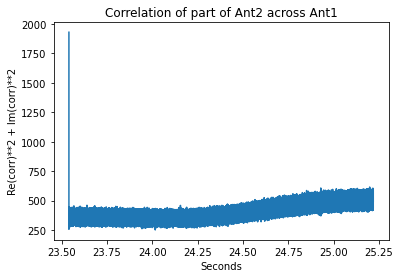

correlation at sample: 0


In [61]:
for i in range(7, 15):
    samples = 2**22
    print(samples / (2.5*1e6), "seconds correlated")
    data1 = np.fromfile(names[7], dtype=np.complex64, count=int(samples)*2, offset=base_offset*8 + samples*8*i + delay_sample*8)
    data2 = np.fromfile(names[6], dtype=np.complex64, count=int(samples), offset=base_offset*8 + samples*8*i)
    corr = signal.correlate(data1, data2, mode="valid")
    x = (signal.correlation_lags(len(data1), len(data2), mode="valid") + base_offset + samples*i) / (2.5*1e6) 
    plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
    plt.xlabel("Seconds")
    plt.ylabel("Re(corr)**2 + Im(corr)**2")
    plt.title("Correlation of part of Ant2 across Ant1")
    # plt.savefig("delay_correlation", dpi=500)
    plt.show()
    print("correlation at sample:", np.argmax(np.real(corr)**2 + np.imag(corr)**2))

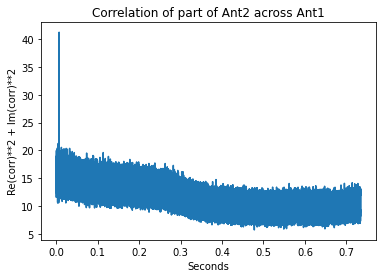

17922


In [69]:
data1 = np.fromfile(names[0], dtype=np.complex64, count=int(2**18)*8, offset=base_offset*8)
data2 = np.fromfile(names[1], dtype=np.complex64, count=int(2**18), offset=base_offset*8)
corr = signal.correlate(data1, data2, mode="valid")
x = signal.correlation_lags(len(data1), len(data2), mode="valid") / (2.5*1e6)
plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
plt.xlabel("Seconds")
plt.ylabel("Re(corr)**2 + Im(corr)**2")
plt.title("Correlation of part of Ant2 across Ant1")
# plt.savefig("delay_correlation", dpi=500)
plt.show()

delay_sample = np.argmax(np.real(corr)**2 + np.imag(corr)**2)
print(delay_sample)

1.6777216 seconds correlated


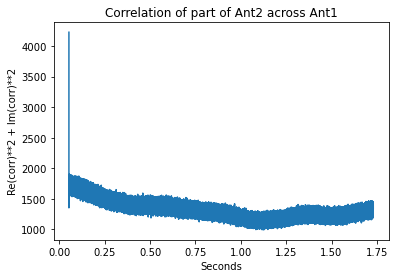

correlation at sample: 0
1.6777216 seconds correlated


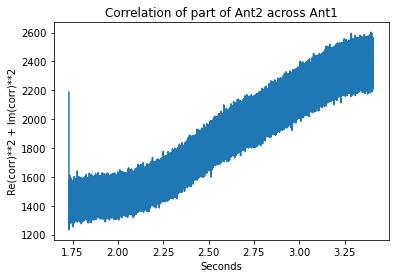

correlation at sample: 4164483
1.6777216 seconds correlated


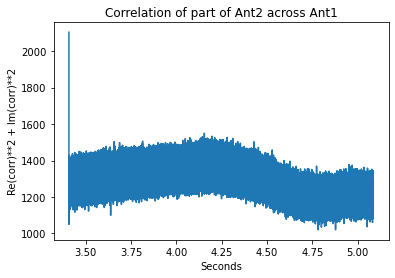

correlation at sample: 0
1.6777216 seconds correlated


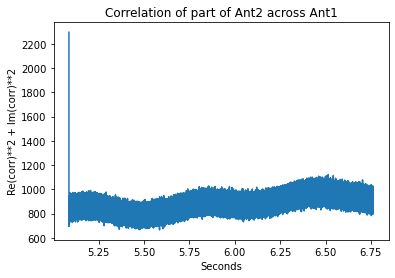

correlation at sample: 0
1.6777216 seconds correlated


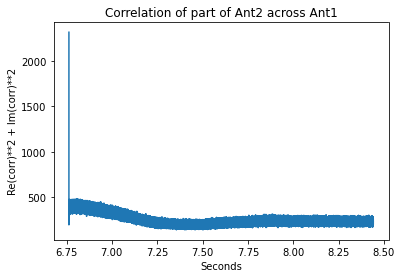

correlation at sample: 0
1.6777216 seconds correlated


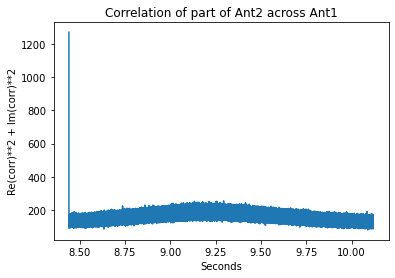

correlation at sample: 0
1.6777216 seconds correlated


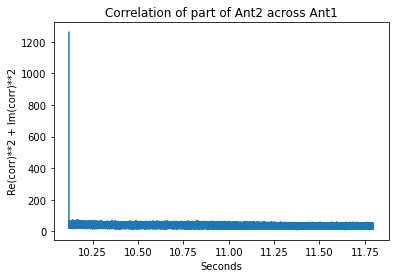

correlation at sample: 0
1.6777216 seconds correlated


KeyboardInterrupt: 

In [66]:
for i in range(0, 20):
    samples = 2**22
    print(samples / (2.5*1e6), "seconds correlated")
    data1 = np.fromfile(names[0], dtype=np.complex64, count=int(samples)*2, offset=base_offset*8 + samples*8*i + delay_sample*8)
    data2 = np.fromfile(names[1], dtype=np.complex64, count=int(samples), offset=base_offset*8 + samples*8*i)
    corr = signal.correlate(data1, data2, mode="valid")
    x = (signal.correlation_lags(len(data1), len(data2), mode="valid") + base_offset + samples*i) / (2.5*1e6) 
    plt.plot(x, np.real(corr)**2 + np.imag(corr)**2)
    plt.xlabel("Seconds")
    plt.ylabel("Re(corr)**2 + Im(corr)**2")
    plt.title("Correlation of part of Ant2 across Ant1")
    # plt.savefig("delay_correlation", dpi=500)
    plt.show()
    print("correlation at sample:", np.argmax(np.real(corr)**2 + np.imag(corr)**2))